In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as  plt
import sklearn
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

I have imported an updated version of the dataset which as  an additional column for risk profile- Good/Bad to make predictions with the dataset whether the transaction is likely to be a fraud or genuine. 


In [ ]:
data= pd.read_csv("../input/german-credit-data-with-risk/german_credit_data.csv")
data= data.drop(['Unnamed: 0'], axis=1)
data

In [ ]:
#LabelBinarizer converts the string categorical variable to binary 
from sklearn.preprocessing import LabelBinarizer
lb= LabelBinarizer()
data["Risk"]= lb.fit_transform(data["Risk"])

Labels are as follows:
**0- Fraud
1- Genuine**

In [ ]:
#using seaborn library, we have used a frequency plot
sns.countplot('Risk', data=data)
plt.title('Risk Distribution', fontsize=14)
plt.show()

On exploring the data, we find that Saving accounts and Checking account are the only 2 columns which have NaN values. 

In [ ]:
Saving_accounts= data["Saving accounts"]
print("No. of null values in savings:")
print(Saving_accounts.isnull().values.sum())
Checking_accounts= data["Checking account"]
print("No. of null values in Checking:")
print(Checking_accounts.isnull().values.sum())


In [ ]:
print(data["Saving accounts"].value_counts())
print(data["Checking account"].value_counts())

In [ ]:
ax1 = sns.scatterplot(x="Age", y="Duration", hue="Risk", data=data)


From the scatterplot we can see a lot of straight lines. Duration is a continous variable from 0-70 . The lines show that it is practically possible to convert them into categories of Time duration groups. 

In [ ]:
ax2 = sns.scatterplot(x="Credit amount", y="Age", hue="Risk", data=data)

An inference that can be made regarding the Credit amount is that credit  loans  involving lower credit amount are likely to be at lower risks (Good)

Our dataset had missing values in Saving account & Checking account. There we no other missing values, the most likely inference is that these people who took credit from the bank didnt actually have a saving accounts or checking account. Maybe because these are senior citizens who need loans for specific purpose like medical treatments, etc or these are students who need loans for educational purposes. 
I'm going to proceed by filling them as NoSavingAcc & NoCheckAcc . 

In [ ]:
data["Saving accounts"].fillna('NoSavingAcc', inplace= True)
data["Checking account"].fillna('NoCheckAcc', inplace= True)


In [ ]:
sns.countplot('Checking account', data=data)
plt.title('Checking account distribution', fontsize=14)
plt.show()

In [ ]:
sns.countplot('Saving accounts', data=data)
plt.title('Saving accounts distribution', fontsize=14)
plt.show()

In [ ]:
interval = (0, 12, 24, 36, 48, 60, 72)
cats =['year1', 'year2', 'year3', 'year4', 'year5', 'year6']
data["Duration"] = pd.cut(data.Duration, interval, labels=cats)


In [ ]:
interval = (18, 25, 35, 60, 120)

cats = ['Student', 'Youth', 'Adult', 'Senior']
data["Age"] = pd.cut(data.Age, interval, labels=cats)


We'll be label encoding a few of our variables and OneHotEncoding some . The reason being that LabelEncoding is preferred where the categorical variables are ordinal, i.e. variables have a signifiant order, say in our original data; Little, moderate, rich are ordinal variables and hence we LabelEncode them. We will be OneHotEncoding the variable Purpose.  

In [ ]:
from sklearn.preprocessing import LabelEncoder
lb= LabelEncoder()
data["Saving accounts"]= lb.fit_transform(data["Saving accounts"])
data["Checking account"]= lb.fit_transform(data["Checking account"])
data["Age"]=lb.fit_transform(data["Age"])
data["Sex"]= lb.fit_transform(data["Sex"])
data["Housing"]=lb.fit_transform(data["Housing"])
data["Duration"]= lb.fit_transform(data["Duration"])
data = data.merge(pd.get_dummies(data.Purpose, drop_first=True, prefix='Purpose'), left_index=True, right_index=True)
del data["Purpose"]

In [ ]:
data

In [ ]:
X= data.drop("Risk", axis= 1)
y= data["Risk"]


In [ ]:
from sklearn.preprocessing import StandardScaler
SC= StandardScaler()
X= SC.fit_transform(X)
X=pd.DataFrame(X)
X

We'll now seperate our data into training and test sets and fit our models on training set and make predictions on the test set 

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.30, random_state= 100)

In [ ]:
y_df=pd.DataFrame(y_train)


Because we have a small dataset and the no. of high-risk credits are very low ( risk profile :**Bad**) . So, we'll try to resample our dataset using SMOTE
(Synthetic minority Oversampling Technique)  It works randomly picingk a point from the minority class and computing the k-nearest neighbors for this point. The synthetic points are added between the chosen point and its neighbors.
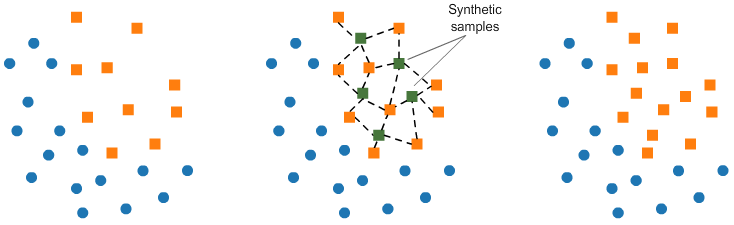

In [ ]:
from imblearn.over_sampling import SMOTE
def sampling_func(X, y):
    smote= SMOTE( ratio= 'minority')
    x_sm, y_sm= smote.fit_sample(X, y)
    return x_sm, y_sm



In [ ]:
def plot_2d_space(X, y, label='Classes'):   
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m
        )
    plt.title(label)
    plt.legend(loc='upper right')
    plt.show()

In [ ]:
#plot the re-sampled data on 2D space
X_sampled, y_sampled = sampling_func(X_train, y_train)
plot_2d_space(X_sampled, y_sampled, 'SMOTE')

In [ ]:
X_sampled= pd.DataFrame(X_sampled)
y_sampled= pd.DataFrame(y_sampled)
y_sampled.columns= y_df.columns
y_sampled["Risk"].value_counts()
df= pd.concat([X_sampled, y_sampled], axis= 1)
df


In [ ]:
#converting to numpy array for use in model
y_sampled=y_sampled.values

In [ ]:
#visaulization of the plot with equal risk distribution 
colors = ["#0101DF", "#DF0101"]
sns.countplot('Risk', data=df, palette=colors)
plt.title('Equally Distributed Classes', fontsize=14)
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report #To evaluate our model
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
# Algorithmns models to be compared
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier

In [ ]:
#use the logistic regression classifier on the dataset
classifier = LogisticRegression()
#setting the Gridsearch parameters to fit the model using best estimates
parameters = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
grid_search = GridSearchCV(estimator= classifier,param_grid= parameters, cv=5,  n_jobs= -1)

In [ ]:
#fitting the model and predictingon the test set 
grid_search.fit(X_sampled, y_sampled.ravel())
y_pred = grid_search.predict(X_test)


In [ ]:
#The confusion matrix plots the predicted positives and negatives
cm= confusion_matrix(y_test, y_pred)
labels = ['Bad', 'Good']
print(classification_report(y_test, y_pred, target_names=labels))
print('accuracy is ',accuracy_score(y_pred,y_test))
print(cm)

In [ ]:
#using SVC classifier
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
svc = SVC()
grid_search = GridSearchCV(estimator= svc, param_grid= parameters, cv=5, n_jobs= -1)

In [ ]:
grid_search.fit(X_sampled, y_sampled.ravel())
y_pred = grid_search.predict(X_test)

In [ ]:
cm= confusion_matrix(y_test, y_pred)
labels = ['Bad', 'Good']
print(classification_report(y_test, y_pred, target_names=labels))
print('accuracy is ',accuracy_score(y_pred,y_test))
print(cm)

In [ ]:
#RandomForestClassifier
parameters = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
 'criterion' :['gini', 'entropy']
}
classifier= RandomForestClassifier()
grid_search= GridSearchCV(estimator=classifier, param_grid=parameters, cv= 5, n_jobs= -1)

In [ ]:
grid_search.fit(X_sampled, y_sampled.ravel())
y_pred = grid_search.predict(X_test)

In [ ]:
cm= confusion_matrix(y_test, y_pred)
labels = ['Bad', 'Good']
print(classification_report(y_test, y_pred, target_names=labels))
print('accuracy is ',accuracy_score(y_pred,y_test))
print(cm)

In [ ]:
#Parameters for XGBoost Classifier
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

In [ ]:
classifier = XGBClassifier(learning_rate=0.01, n_estimators=600, objective='binary:logistic',
                    silent=True, nthread=1)

In [ ]:
random_search = RandomizedSearchCV(classifier, param_distributions=params,  n_jobs=4, cv=10, verbose=2, random_state=0 )


In [ ]:
X_test= pd.DataFrame(X_test)
X_sampled.columns= X_train.columns

In [ ]:
random_search.fit(X_sampled, y_sampled.ravel())
y_pred= random_search.predict(X_test)

In [ ]:
cm= confusion_matrix(y_test, y_pred)
labels = ['Bad', 'Good']
print(classification_report(y_test, y_pred, target_names=labels))
print('accuracy is ',accuracy_score(y_pred,y_test))
print(cm)

In [ ]:
GNB = GaussianNB()
# Fitting with train data
GNB.fit(X_sampled, y_sampled.ravel())
y_pred= GNB.predict(X_test)

In [ ]:
cm= confusion_matrix(y_test, y_pred)
labels = ['Bad', 'Good']
print(classification_report(y_test, y_pred, target_names=labels))
print('accuracy is ',accuracy_score(y_pred,y_test))
print(cm)

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
Model=LinearDiscriminantAnalysis()
Model.fit(X_sampled,y_sampled.ravel())
y_pred=Model.predict(X_test)
labels = ['Bad', 'Good']
print(classification_report(y_test,y_pred, target_names= labels))
print(confusion_matrix(y_pred,y_test))
#Accuracy Score
print('accuracy is ',accuracy_score(y_pred,y_test))

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

Model = KNeighborsClassifier(n_neighbors=8)
Model.fit(X_train, y_train)

y_pred = Model.predict(X_test)

# Summary of the predictions made by the classifier
labels = ['Bad', 'Good']
print(classification_report(y_test, y_pred, target_names= labels))
print(confusion_matrix(y_test, y_pred))
# Accuracy score

print('accuracy is',accuracy_score(y_pred,y_test))

From the different classifiers, we trained our model on, Our aim is not iimproving the accuracy score, but the Precision and Recall values. For a good credit risk, Precision/Recall values are likely to be high, but, for a Bad credit risk, the values are most likely to be lower, because the dataset is limited to 1000 values only where nearly 300 are at a bad credit risk. 

Comparing the Recall scores for each model, we are selecting RandomForest classifier as the best classifier to train the model on. We have a Recall score  of 75% for good credit risk data, and 58% for Bad credit risk data.